<a href="https://colab.research.google.com/github/sedaoturak/cVAE_Mechanical_MNIST/blob/main/cVAE_Mechanical_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install dependencies

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import datasets, models, transforms
from torch.autograd.variable import Variable
import matplotlib.pyplot as plt
import numpy as np
import random
import tqdm.notebook

# Load data

##Mechanical MNIST

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

with open('/content/drive/My Drive/mnist_img_train.txt', 'r') as f: 
  g = np.loadtxt(f)
with open('/content/drive/My Drive/summary_psi_train_all.txt', 'r') as f:
  e = np.loadtxt(f)

Mounted at /content/drive


In [ ]:
g.shape, e.shape

((60000, 784), (60000, 13))

In [ ]:
g.reshape((60000,28,28))

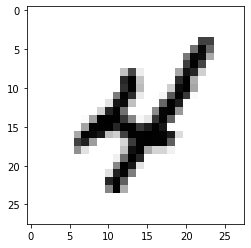

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(g.reshape((60000,28,28))[9,:,:], interpolation='nearest', cmap='binary')
plt.show()

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
e_scaled = scaler.fit_transform(e[:,12].reshape(-1, 1))
e_scaled.shape, e_scaled.ravel().shape

((60000, 1), (60000,))

In [ ]:
images = g.reshape((60000,28,28))
energies = e_scaled.ravel()

images.shape, energies.shape

((60000, 28, 28), (60000,))

###Custom dataloader

In [ ]:
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import random_split

In [ ]:
class Dataset():
  'Characterizes a dataset for PyTorch'
  def __init__(self, list_IDs, labels, transform):
        'Initialization'
        self.labels = labels
        self.list_IDs = list_IDs
        self.transform = transform

  def __len__(self):
        'Denotes the total number of samples' 
        return len(self.list_IDs)

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        ID = self.list_IDs[index]

        # Load data and get label
        # X = self.transform(ID)
        X = ID
        y = self.labels[index]
        return X, y 

In [ ]:
b, w, h, = [*images.shape]
print(images.shape)
images_wb = np.repeat(images[..., np.newaxis], 3, -1)
print(images_wb.shape)
images_wb = images_wb.reshape(b, 3, w, h)
print(images_wb.shape)

(60000, 28, 28)
(60000, 28, 28, 3)
(60000, 3, 28, 28)


In [ ]:
transform = transforms.Compose([
      # transforms.ToPILImage(),
      #T.RandomRotation(degrees= (0, 180)),
      # transforms.RandomRotation(180),
      # transforms.RandomRotation(90),
     
      # transforms.RandomHorizontalFlip(0.5),
      # transforms.RandomVerticalFlip(0.5),
      #transforms.ColorJitter(brightness=(0.5,1.5),contrast=(1),saturation=(0.5,1.5),hue=(-0.1,0.1)),
      transforms.ToTensor(),
      #transforms.Normalize([0.2732, 0.2728, 0.2713], [0.1937, 0.1943, 0.1933]),
        ])

# Datasets
normalized_images = images_wb / 255
data = torch.tensor(normalized_images, dtype=torch.float32)    #all_img
target = torch.tensor(np.array(energies), dtype=torch.float32)   #target

# Generators
# Train, validation split
from torch.utils.data import DataLoader, TensorDataset
dataset = Dataset(data, target, transform)

In [ ]:
normalized_images[0]

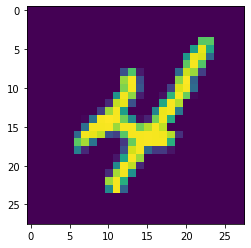

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.imshow((images/255)[9,:,:])
plt.show()

In [ ]:
train_set_size = int(len(dataset)*0.8)
val_set_size = int(len(dataset)*0.2)

train, val  = random_split(dataset, [train_set_size, val_set_size])
batch_size = 100
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, drop_last=True, num_workers= 2)#, num_workers= 2)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=True, drop_last=True)

#Model (CNN-cVAE)

In [ ]:
class ConvBlock2D(torch.nn.Module):
    def __init__(self, out_channels, kernel_size, padding, is_conv=True):
        super(ConvBlock2D, self).__init__()
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.padding = padding
        self.pool_op = torch.nn.MaxPool2d(2, ) if is_conv \
                  else torch.nn.Upsample(scale_factor=2, mode='linear', align_corners=False)
        self.conv = torch.nn.LazyConv2d(out_channels, kernel_size, padding=padding)
        self.bn = torch.nn.BatchNorm2d(out_channels, eps=0.001, momentum=0.99)
        self.relu = torch.nn.LeakyReLU()
    def forward(self, x):
        x = self.conv(x)
        print(f'x size after conv layers: {x.size()}')
        x = self.bn(x)
        print(f'x size after batch norm: {x.size()}')
        x = self.relu(x)
        return x

class ConvEncoder(torch.nn.Module):
    def __init__(self, n_channels, width, latent_size):
        super(ConvEncoder, self).__init__()
        self.latent_size = latent_size
        self.kernel_size = width
        self.conv = nn.Sequential(*[ConvBlock2D(ch, self.kernel_size, self.kernel_size//2) for ch in n_channels])
        self.dense = nn.LazyLinear(self.latent_size)
    def forward(self, x, c):
        print(f'encoder xsize: {x.size()}, c size: {c.size()}')
        x = self.conv(x).view(x.shape[0], -1)
        print(f'encoder after conv x dim:  {x.dim()}, c dim: {c.dim()}')
        x = torch.cat([x, c], dim=-1)
        print(f'encoder x size after concatenating with condition: {x.size()}')

        mu = self.dense(x)
        logVar = self.dense(x)
        return mu,logVar

class ConvDecoder(torch.nn.Module):
    def __init__(self, n_channels, width, output_size):
        super(ConvDecoder, self).__init__()
        self.output_size = output_size
        self.kernel_size = width
        self.conv = nn.Sequential(*[ConvBlock2D(ch, self.kernel_size, self.kernel_size//2, is_conv=False) for ch in n_channels])
        self.dense_out = nn.LazyLinear(self.output_size)
        self.act = nn.Sigmoid()
    def forward(self, x, c):
        print(f'decoder x size: {x.size()}, c size: {c.size()}')
        x = torch.cat([x, c], dim=-1)
        print(f'decoder x size after concatenating with condition in decoder: {x.size()}')
        x = self.conv(x.view(x.shape[0], -1, 1, 1))
        print(f'decoder x size after view command in decoder: {x.size()}')
        x = self.dense_out(x)
        print(f'decoder x size after dense layer: {x.size()}')
        x = self.act(x)
        return x
class Reparameterize(torch.nn.Module):
    def __init__(self):
        super(Reparameterize, self).__init__()
    def forward(self, mu, logVar):
        std = torch.exp(logVar/2)
        eps = torch.randn_like(std)
        return mu + std * eps

class ConvVAE(torch.nn.Module):
    def __init__(self,lat_dim, e_n_channels, d_n_channels, e_width, d_width):
        super(ConvVAE, self).__init__()
        self.encoder = ConvEncoder(e_n_channels, e_width, latent_size=lat_dim)
        self.reparameterize = Reparameterize()
        self.decoder = ConvDecoder(d_n_channels, d_width, output_size=784)
        self.defc = nn.LazyLinear(784)
    def forward(self, x, c):
        print(f'input size:  {x.size()}, condition dim: {c.size()}')
        mu,logVar = self.encoder(x,c)
        print(f'mu size:  {mu.size()}')
        z = self.reparameterize(mu, logVar)
        print(f'z size after reparameterization: {z.size()}')
        z = self.defc(z)
        print(f'z size after defc: {z.size()}, c size: {c.size()}')
        print(f'after unsqueeze(1), z size: {z.unsqueeze(1).size()}, c size: {c.unsqueeze(1).size()}')
        out = self.decoder(z.unsqueeze(1), c.unsqueeze(1))
        print(f'output size in decoder: {out.size()}')
        return z, out, mu, logVar

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def train_model(*solution):
  lat_dim, e_n_ch, e_width, e_n_conv, d_n_ch, d_width, d_n_conv = [*solution]
  params = {}

  params['lat_dim'] = lat_dim
  params['e_n_channels'] = e_n_ch
  params['d_n_channels'] = d_n_ch
  params['e_width'], params['d_width'] = e_width, d_width

  # print(params)

  # initialize the network and the Adam optimizer
  cVAE_model = ConvVAE(**params).to(device)
  learning_rate = 1e-3
  optimizer = torch.optim.Adam(cVAE_model.parameters(), lr=learning_rate)

  # define loss function
  def loss_function(y_pred, yt, mu, logVar):
    criterion = torch.nn.MSELoss(reduction='mean')
    reproduction_loss = criterion(y_pred.reshape(y_pred.shape[0],-1,28,28), yt.to(device))

    beta = 5e-1
    KLD = torch.mean(-0.5 * torch.sum(1 + logVar - mu ** 2 - logVar.exp()))
    return reproduction_loss + beta*KLD, reproduction_loss, KLD

  def train_loss():
    cVAE_model.train()
    for i, data in enumerate(train_loader, 0):
      inputs, conditions = data
      # print(inputs.shape, conditions.shape)
      inputs, conditions = inputs.to(device), conditions.reshape(-1,1).to(device)
      # print(inputs.shape, conditions.shape)
      optimizer.zero_grad()

      # Forward pass
      z_train, pred, mu, logVar = cVAE_model(inputs, conditions)
      # print(f"input size: {inputs.size()}, pred size: {pred.size()}")

      # Compute Loss
      total_loss, rep_loss, KLD_loss = loss_function(pred, inputs, mu, logVar)

      # Backpropagation based on the loss
      total_loss.backward()
      optimizer.step()
    return total_loss, rep_loss, KLD_loss

  def valid_loss():
    cVAE_model.eval()
    for i, data in enumerate(val_loader, 0):
      inputs, conditions = data
      inputs, conditions = inputs.to(device), conditions.reshape(-1,1).to(device)
      # Forward pass
      z_val, pred, mu, logVar = cVAE_model(inputs, conditions)

      # Compute Loss
      total_loss, rep_loss, KLD_loss = loss_function(pred, inputs, mu, logVar)

    return total_loss, rep_loss, KLD_loss

  history = {'train_loss_total': [], 'train_loss_rep': [], 'train_loss_KLD': [],
             'val_loss_total': [],'val_loss_rep': [], 'val_loss_KLD': []}

  num_epochs = 1
  for epoch in tqdm.notebook.tqdm(range(num_epochs)):

    train_total_loss, train_rep_loss, train_KLD_loss = train_loss()
    val_total_loss, val_rep_loss, val_KLD_loss = valid_loss()

    history['train_loss_total'].append(train_total_loss.item())
    history['train_loss_rep'].append(train_rep_loss.item())
    history['train_loss_KLD'].append(train_KLD_loss.item())
    history['val_loss_total'].append(val_total_loss.item())
    history['val_loss_rep'].append(val_rep_loss.item())
    history['val_loss_KLD'].append(val_KLD_loss.item())
    # print(val_total_loss.item())

  return history, val_total_loss, cVAE_model

In [ ]:
pars = [2, [16,32,16],  4,  3, [16,32,16,3],  4,  3]
history, val_loss, cVAE_model = train_model(*pars)

  0%|          | 0/1 [00:00<?, ?it/s]

input size:  torch.Size([100, 3, 28, 28]), condition dim: torch.Size([100, 1])
encoder xsize: torch.Size([100, 3, 28, 28]), c size: torch.Size([100, 1])
x size after conv layers: torch.Size([100, 16, 29, 29])
x size after batch norm: torch.Size([100, 16, 29, 29])
x size after conv layers: torch.Size([100, 32, 30, 30])
x size after batch norm: torch.Size([100, 32, 30, 30])
x size after conv layers: torch.Size([100, 16, 31, 31])
x size after batch norm: torch.Size([100, 16, 31, 31])
encoder after conv x dim:  2, c dim: 2
encoder x size after concatenating with condition: torch.Size([100, 15377])
mu size:  torch.Size([100, 2])
z size after reparameterization: torch.Size([100, 2])
z size after defc: torch.Size([100, 784]), c size: torch.Size([100, 1])
after unsqueeze(1), z size: torch.Size([100, 1, 784]), c size: torch.Size([100, 1, 1])
decoder x size: torch.Size([100, 1, 784]), c size: torch.Size([100, 1, 1])
decoder x size after concatenating with condition in decoder: torch.Size([100, 1

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([100, 3, 28, 28])) that is different to the input size (torch.Size([100, 15, 28, 28])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: ignored

##Loss

Text(0, 0.5, 'Log of Total Loss')

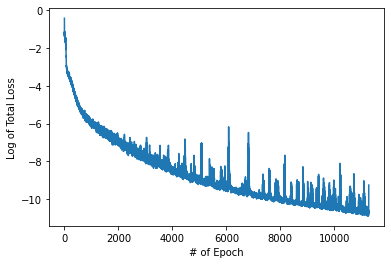

In [ ]:
# Plot loss
plt.plot(np.log(loss_data))
plt.xlabel('# of Epoch')
plt.ylabel('Log of Total Loss')

In [ ]:
len(loss_data)

11280

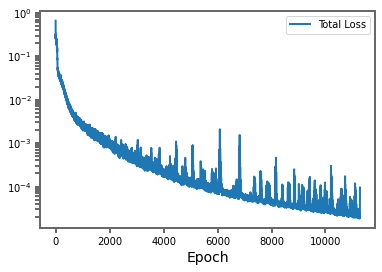

In [ ]:
fig, ax = plt.subplots()
ax.plot(loss_data, label='Total Loss', linewidth=2)
# ax.plot(rep_loss, label='Reconstruction Loss', linewidth=2)
# ax.plot(KLD_loss, label='KLD Loss', linewidth=2)

ax.set_xlabel('Epoch', fontsize=14)
ax.set_yscale('log')

# ax.tick_params(axis='x', labelsize=12)
# ax.tick_params(axis='y', labelsize=12)
ax.xaxis.set_tick_params(width=2, length=5, color='dimgrey')
ax.yaxis.set_tick_params(width=2, length=5, color='dimgrey')
ax.tick_params(which='minor', width=2, length=5, color='dimgrey')
plt.setp(ax.spines.values(), linewidth=2, color='dimgrey')
ax.legend()

Text(0, 0.5, 'Log of Reproduction Loss')

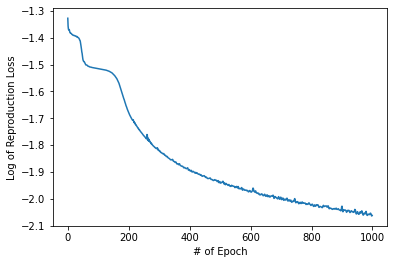

In [ ]:
# Plot reproduction loss
plt.plot(np.log(rep_loss))
plt.xlabel('# of Epoch')
plt.ylabel('Log of Reproduction Loss')

Text(0, 0.5, 'Log of KLD Loss')

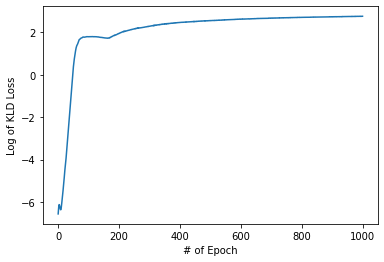

In [ ]:
# Plot KLD loss
plt.plot(np.log(KLD_loss))
plt.xlabel('# of Epoch')
plt.ylabel('Log of KLD Loss')

##Latent Space

In [ ]:
import plotly.graph_objects as go
layout = go.Layout(
    # title = 'marker size: z4, color bar: z5',
                  width=800, height=600,
                  scene=dict(xaxis=dict(title="z1"),
                              yaxis=dict(title="z2"),
                              zaxis=dict(title="z3")),
                   font=dict(
                           size=13
                           ))

d4= z_train[:,3].detach().numpy()-(z_train[:,3].detach().numpy().min()-1)
d5= z_train[:,4].detach().numpy()-(z_train[:,4].detach().numpy().min()-1)

plot = go.Figure(data=[go.Scatter3d(
                            x = z_train[:,0].detach().numpy(), 
                            y = z_train[:,1].detach().numpy(),
                            z = z_train[:,2].detach().numpy(),
                            mode = 'markers',
                            marker=dict(
                                size=d4,
                                color=d5.tolist(), #c_train[:,0]
                                opacity=0.8,
                                colorscale='Viridis',
                                showscale=True,
                                colorbar=dict(title='z5',
                                              thickness=10,
                                              ticks="outside",
                                              orientation='v'))),
], layout = layout)


plot.show()

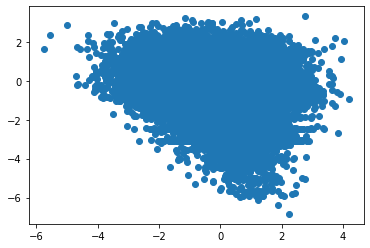

In [ ]:
fig, ax = plt.subplots()
xy = z_train[:, :2].detach().numpy()
ax.scatter(*xy.T)

###Sampling

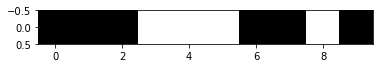

In [ ]:
plt.imshow(X_train[385].reshape(1, -1), cmap='gray')
plt.savefig("bit1.png", transparent=True)

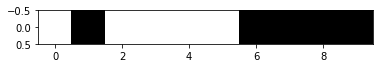

In [ ]:
plt.imshow(X_train[526].reshape(1, -1), cmap='gray')
plt.savefig("bit2.png", transparent=True)

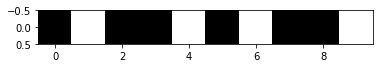

In [ ]:
plt.imshow(X_train[6].reshape(1, -1), cmap='gray')
plt.savefig("bit3.png", transparent=True)

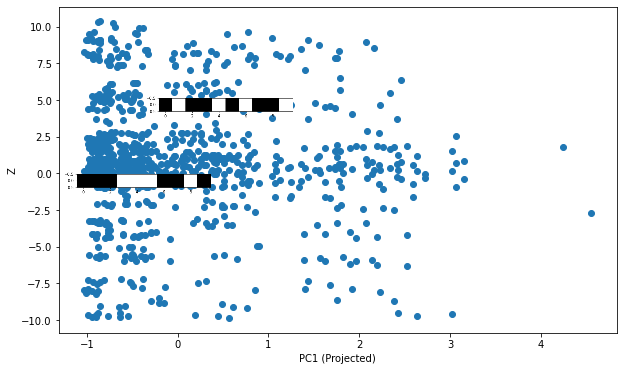

In [ ]:
from IPython.core.pylabtools import figsize
from matplotlib.patches import Circle
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)
from matplotlib.cbook import get_sample_data
fig, ax = plt.subplots(figsize=(10,6))  # create the plot

ax.scatter(x = c_train[:,0], y = ztrain[:,0])
ax.set_ylabel('Z')
ax.set_xlabel('PC1 (Projected)')

arr_img1 = plt.imread("bit1.png", format='png')  # could also load with PIL
imagebox1 = OffsetImage(arr_img1, zoom=0.4)  # create an image
ab = AnnotationBbox(imagebox1, [c_train[385,0], ztrain[385]+0.3], frameon=False)  # create the annotationbox "artist"
ax.add_artist(ab)

arr_img2 = plt.imread("bit3.png", format='png')  # could also load with PIL
imagebox2 = OffsetImage(arr_img2, zoom=0.4)  # create an image
ab2 = AnnotationBbox(imagebox2, [c_train[6,0]-0.4, ztrain[6]+0.3], frameon=False)  # create the annotationbox "artist"
ax.add_artist(ab2)

In [ ]:
out[54]

array([-0.74297786,  0.2777279 ,  1.0591334 ,  0.48403704,  1.6882572 ,
        1.6873174 ,  1.2460115 ,  1.3422222 ,  0.67121774,  0.5423212 ],
      dtype=float32)

##Prediction

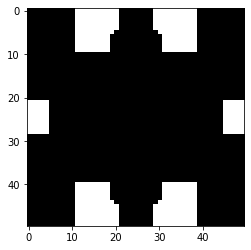

In [ ]:
plt.imshow(X_test[3, :,:], interpolation='nearest', cmap='binary')
plt.show()

In [ ]:
X_test[3, :,:].shape

(50, 50)

In [ ]:
y_test = X_test[:4, :,:].reshape(4, 1, 50,50)
ytest = Variable(torch.Tensor(y_test))

mu_test, logVar_test = cVAE(16).encoder(ytest)
ztest = cVAE(16).reparameterize(mu_test, logVar_test)
# ztest = ztest.detach().numpy() 

In [ ]:
ztest.shape

torch.Size([40000, 16])

In [ ]:
out, _, _, _ = cVAE(16).decoder(ztest)
out = out.detach().numpy() 

In [ ]:
out.shape

(1, 50, 50)

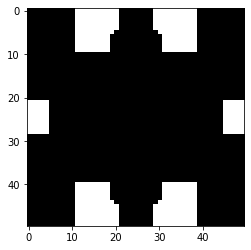

In [ ]:
plt.imshow(X_test[3,:,:], interpolation='nearest', cmap='binary')
plt.show()

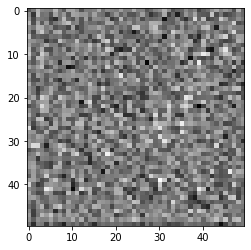

In [ ]:

plt.imshow(out[0,:,:], interpolation='nearest', cmap='binary')
plt.show()

Text(0.5, 1.0, 'Prediction (Rounded)')

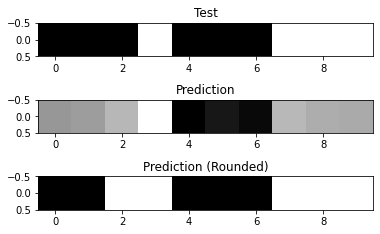

In [ ]:
f, ax = plt.subplots(3,1)
index = 11
ax[0].imshow(X_test[index].reshape(1, -1), cmap='gray')
ax[0].set_title('Test')
ax[1].imshow(out[index].reshape(1, -1), cmap='gray')
ax[1].set_title('Prediction')
ax[2].imshow(np.round(out[index]).reshape(1, -1), cmap='gray')
ax[2].set_title('Prediction (Rounded)')

Text(0.5, 1.0, 'Prediction (Rounded)')

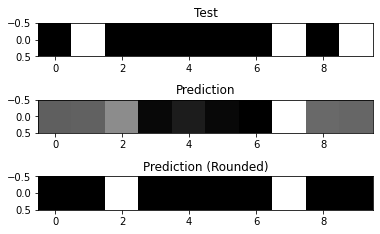

In [ ]:
f, ax = plt.subplots(3,1)
index = 22
ax[0].imshow(X_test[index].reshape(1, -1), cmap='gray')
ax[0].set_title('Test')
ax[1].imshow(out[index].reshape(1, -1), cmap='gray')
ax[1].set_title('Prediction')
ax[2].imshow(np.round(out[index]).reshape(1, -1), cmap='gray')
ax[2].set_title('Prediction (Rounded)')

Text(0.5, 1.0, 'Prediction (Rounded)')

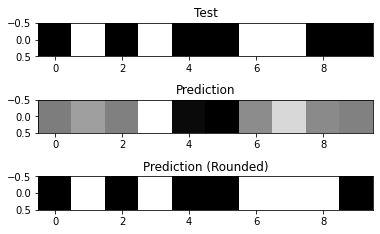

In [ ]:
f, ax = plt.subplots(3,1)
index = 57
ax[0].imshow(X_test[index].reshape(1, -1), cmap='gray')
ax[0].set_title('Test')
ax[1].imshow(out[index].reshape(1, -1), cmap='gray')
ax[1].set_title('Prediction')
ax[2].imshow(np.round(out[index]).reshape(1, -1), cmap='gray')
ax[2].set_title('Prediction (Rounded)')